In [1]:
import numpy as np
import pandas as pd

import re
import random
import os
import math

from pandas import Series
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, roc_auc_score, confusion_matrix

# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
bank = pd.read_csv('train.csv')

In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [4]:
bank.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
32472,47425,GRD,F,26,N,N,1,1,2,1,3,35000,N,0
39130,36966,SCH,M,33,N,N,0,0,4,1,2,15000,N,0
23547,65918,SCH,F,22,N,N,2,0,1,2,3,15000,N,0
26050,22299,SCH,F,50,N,N,0,0,2,1,3,7500,N,0
43305,79373,GRD,F,58,N,N,0,1,0,1,2,30000,N,0


In [5]:
bank.shape

(73799, 14)

In [6]:
# посмотрим на пропуски по столбцам
bank.isnull().sum().sort_values(ascending=False)

education           307
default               0
foreign_passport      0
income                0
work_address          0
home_address          0
bki_request_cnt       0
good_work             0
decline_app_cnt       0
car_type              0
car                   0
age                   0
sex                   0
client_id             0
dtype: int64

In [7]:
bank['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [8]:
bank['education'].value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

<AxesSubplot:>

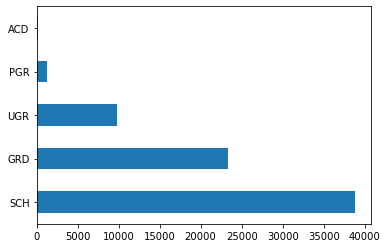

In [9]:
bank['education'].value_counts().plot.barh()

In [10]:
bin_cols = ['sex', 'car', 'car_type',  'foreign_passport', 'good_work']
cat_cols = ['education',  'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']

In [11]:
# посмотрим на распределение данных:
def column_info(column):
    print('Информация о столбце {}'.format(column))
    print(f'Количество пустых строк: {bank[column].isnull().sum()}')
    print('Распределение столбца:', pd.DataFrame(bank[column].value_counts()))
    print(bank[column].describe())
    if bank[column].dtype == 'int64' or bank[column].dtype == 'float64':
        median = bank[column].median()
        perc25 = bank[column].quantile(0.25)
        perc75 = bank[column].quantile(0.75)
        IQR = perc75 - perc25
        print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR} Границы выбросов: [{perc25 - 1.5*IQR},{perc75 + 1.5*IQR}]')
        bank[column].hist(bins = 10, label = 'IQR')
        plt.legend()
    print('\n')

In [12]:
for column in bank.columns:
    if bank[column].dtypes == 'object':
        print(column_info(column))

Информация о столбце education
Количество пустых строк: 307
Распределение столбца:      education
SCH      38860
GRD      23365
UGR       9816
PGR       1257
ACD        194
count     73492
unique        5
top         SCH
freq      38860
Name: education, dtype: object


None
Информация о столбце sex
Количество пустых строк: 0
Распределение столбца:      sex
F  41562
M  32237
count     73799
unique        2
top           F
freq      41562
Name: sex, dtype: object


None
Информация о столбце car
Количество пустых строк: 0
Распределение столбца:      car
N  49832
Y  23967
count     73799
unique        2
top           N
freq      49832
Name: car, dtype: object


None
Информация о столбце car_type
Количество пустых строк: 0
Распределение столбца:    car_type
N     59791
Y     14008
count     73799
unique        2
top           N
freq      59791
Name: car_type, dtype: object


None
Информация о столбце foreign_passport
Количество пустых строк: 0
Распределение столбца:    foreign_passport
N   

In [13]:
bank.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'],
      dtype='object')

Информация о столбце income
Количество пустых строк: 0
Распределение столбца:         income
30000     7009
25000     6061
20000     5471
40000     4935
50000     4470
...        ...
37600        1
27350        1
27478        1
53800        1
426000       1

[966 rows x 1 columns]
count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64
25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0 Границы выбросов: [-22000.0,90000.0]




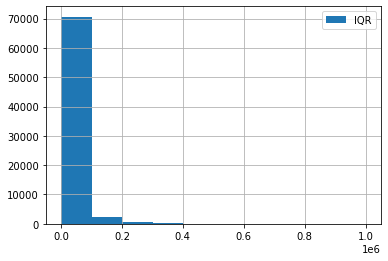

In [15]:
column_info('income')

Информация о столбце decline_app_cnt
Количество пустых строк: 0
Распределение столбца:     decline_app_cnt
0             61214
1              8397
2              2468
3               903
4               414
5               165
6               113
7                48
9                24
8                19
10               11
11                9
13                3
12                2
14                2
16                2
24                1
15                1
19                1
22                1
33                1
count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0 Границы выбросов: [0.0,0.0]




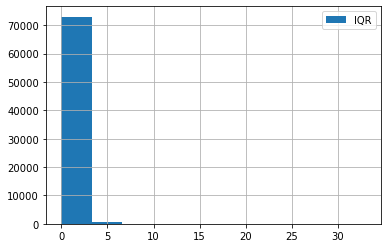

In [16]:
column_info('decline_app_cnt')

Информация о столбце bki_request_cnt
Количество пустых строк: 0
Распределение столбца:     bki_request_cnt
0             19381
1             18276
2             13749
3              9187
4              5627
5              3268
6              1704
7               852
8               508
9               299
10              225
11              188
12              144
13               94
14               86
15               54
16               35
18               22
17               19
19               18
21               12
24               11
20                9
23                7
28                4
22                4
32                2
27                2
26                2
25                2
46                1
29                1
33                1
34                1
36                1
41                1
45                1
53                1
count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
7

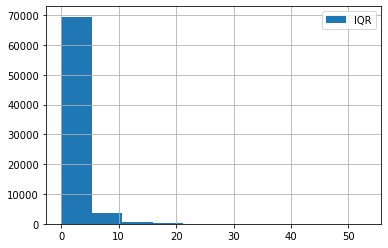

In [17]:
column_info('bki_request_cnt')

Информация о столбце age
Количество пустых строк: 0
Распределение столбца:      age
31  2727
28  2705
30  2693
29  2659
27  2645
26  2528
32  2501
34  2395
33  2314
35  2259
25  2202
36  2159
37  2118
38  2088
39  2082
42  1973
40  1932
24  1873
41  1857
43  1770
44  1690
23  1509
45  1487
50  1424
47  1418
46  1407
48  1404
52  1387
51  1385
53  1326
54  1326
49  1304
55  1230
56  1114
57  1040
22   937
59   925
58   881
60   851
21   849
61   661
62   576
63   477
64   449
65   422
66   309
67   248
68   165
69    81
70    32
71     3
72     2
count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0 Границы выбросов: [3.0,75.0]




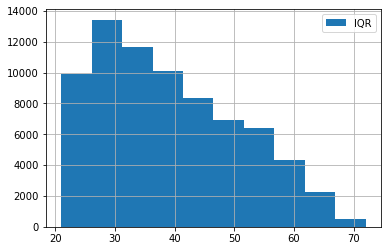

In [18]:
column_info('age')

/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


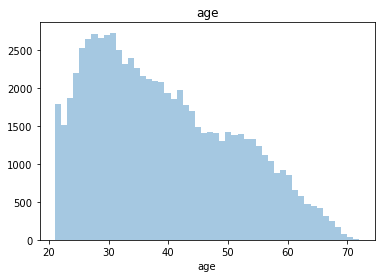

/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


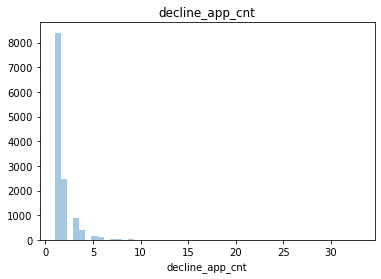

/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


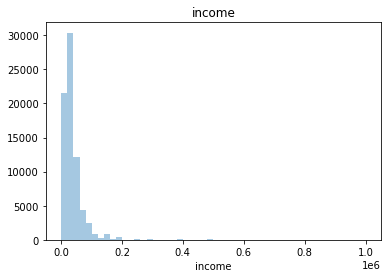

/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


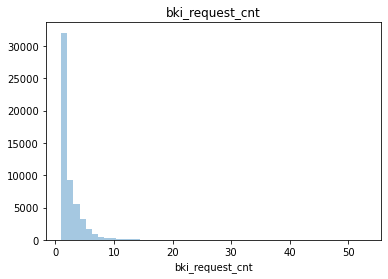

In [19]:
for i in num_cols:
    plt.figure()
    sns.distplot(bank[i][bank[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [20]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='default',
                data=bank.loc[bank.loc[:, column].isin(
                    bank.loc[:, column].value_counts().index[:29])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

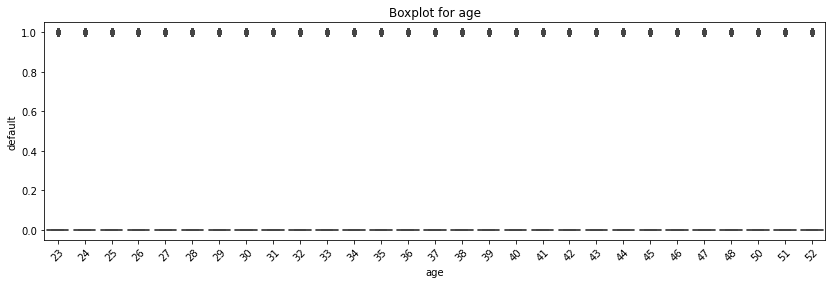

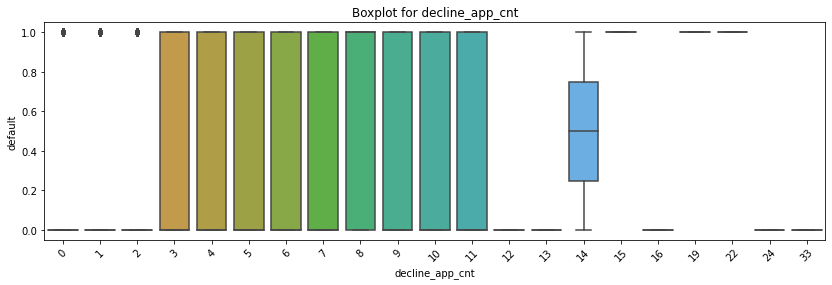

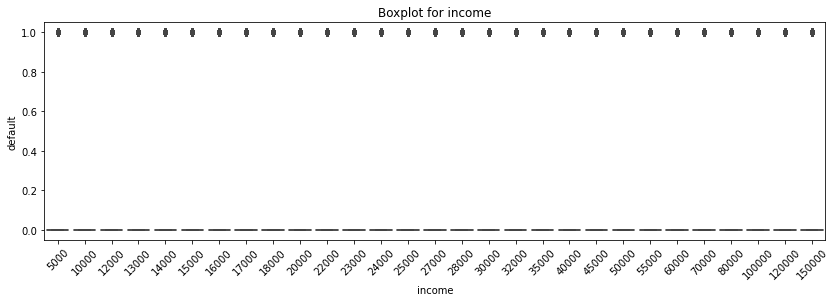

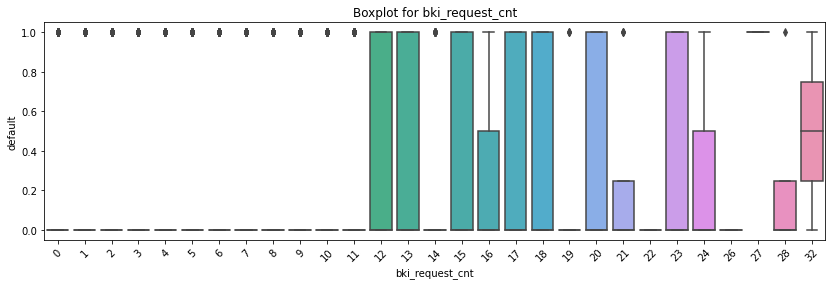

In [22]:
for column in num_cols:
    get_boxplot(column)

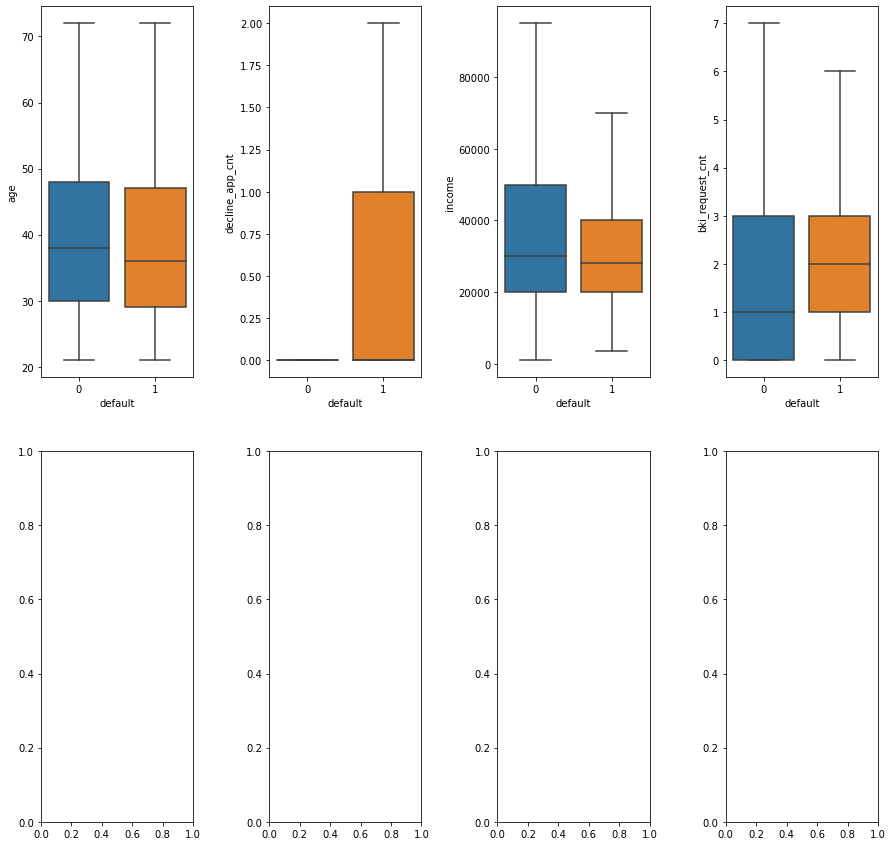

In [23]:
# визуализация числовых переменных с использованием boxplot

fig, axes = plt.subplots(2,4,figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()

for i in range (len(num_cols)):
    sns.boxplot(x = "default", y = num_cols[i], data=bank,orient='v', ax=axes[i], showfliers=False)

<AxesSubplot:>

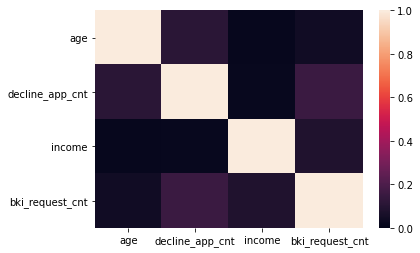

In [25]:
sns.heatmap(bank[num_cols].corr().abs(), vmin=0, vmax=1)

In [24]:
bank.corr()

,client_id,age,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,default
client_id,1.000000,0.015435,-0.021417,0.004749,-0.029028,0.165555,0.165777,-0.000099,-0.039242
age,0.015435,1.000000,-0.111175,-0.076158,0.046265,0.010392,-0.006299,-0.018900,-0.025004
decline_app_cnt,-0.021417,-0.111175,1.000000,-0.027359,0.155894,0.012530,0.016234,-0.021687,0.113682
good_work,0.004749,-0.076158,-0.027359,1.000000,0.005738,-0.003624,-0.008535,0.022705,-0.043361
bki_request_cnt,-0.029028,0.046265,0.155894,0.005738,1.000000,0.008183,0.005553,0.082983,0.078242
home_address,0.165555,0.010392,0.012530,-0.003624,0.008183,1.000000,0.728139,0.038343,0.084637
work_address,0.165777,-0.006299,0.016234,-0.008535,0.005553,0.728139,1.000000,0.049721,0.081582
income,-0.000099,-0.018900,-0.021687,0.022705,0.082983,0.038343,0.049721,1.000000,-0.039752
default,-0.039242,-0.025004,0.113682,-0.043361,0.078242,0.084637,0.081582,-0.039752,1.000000


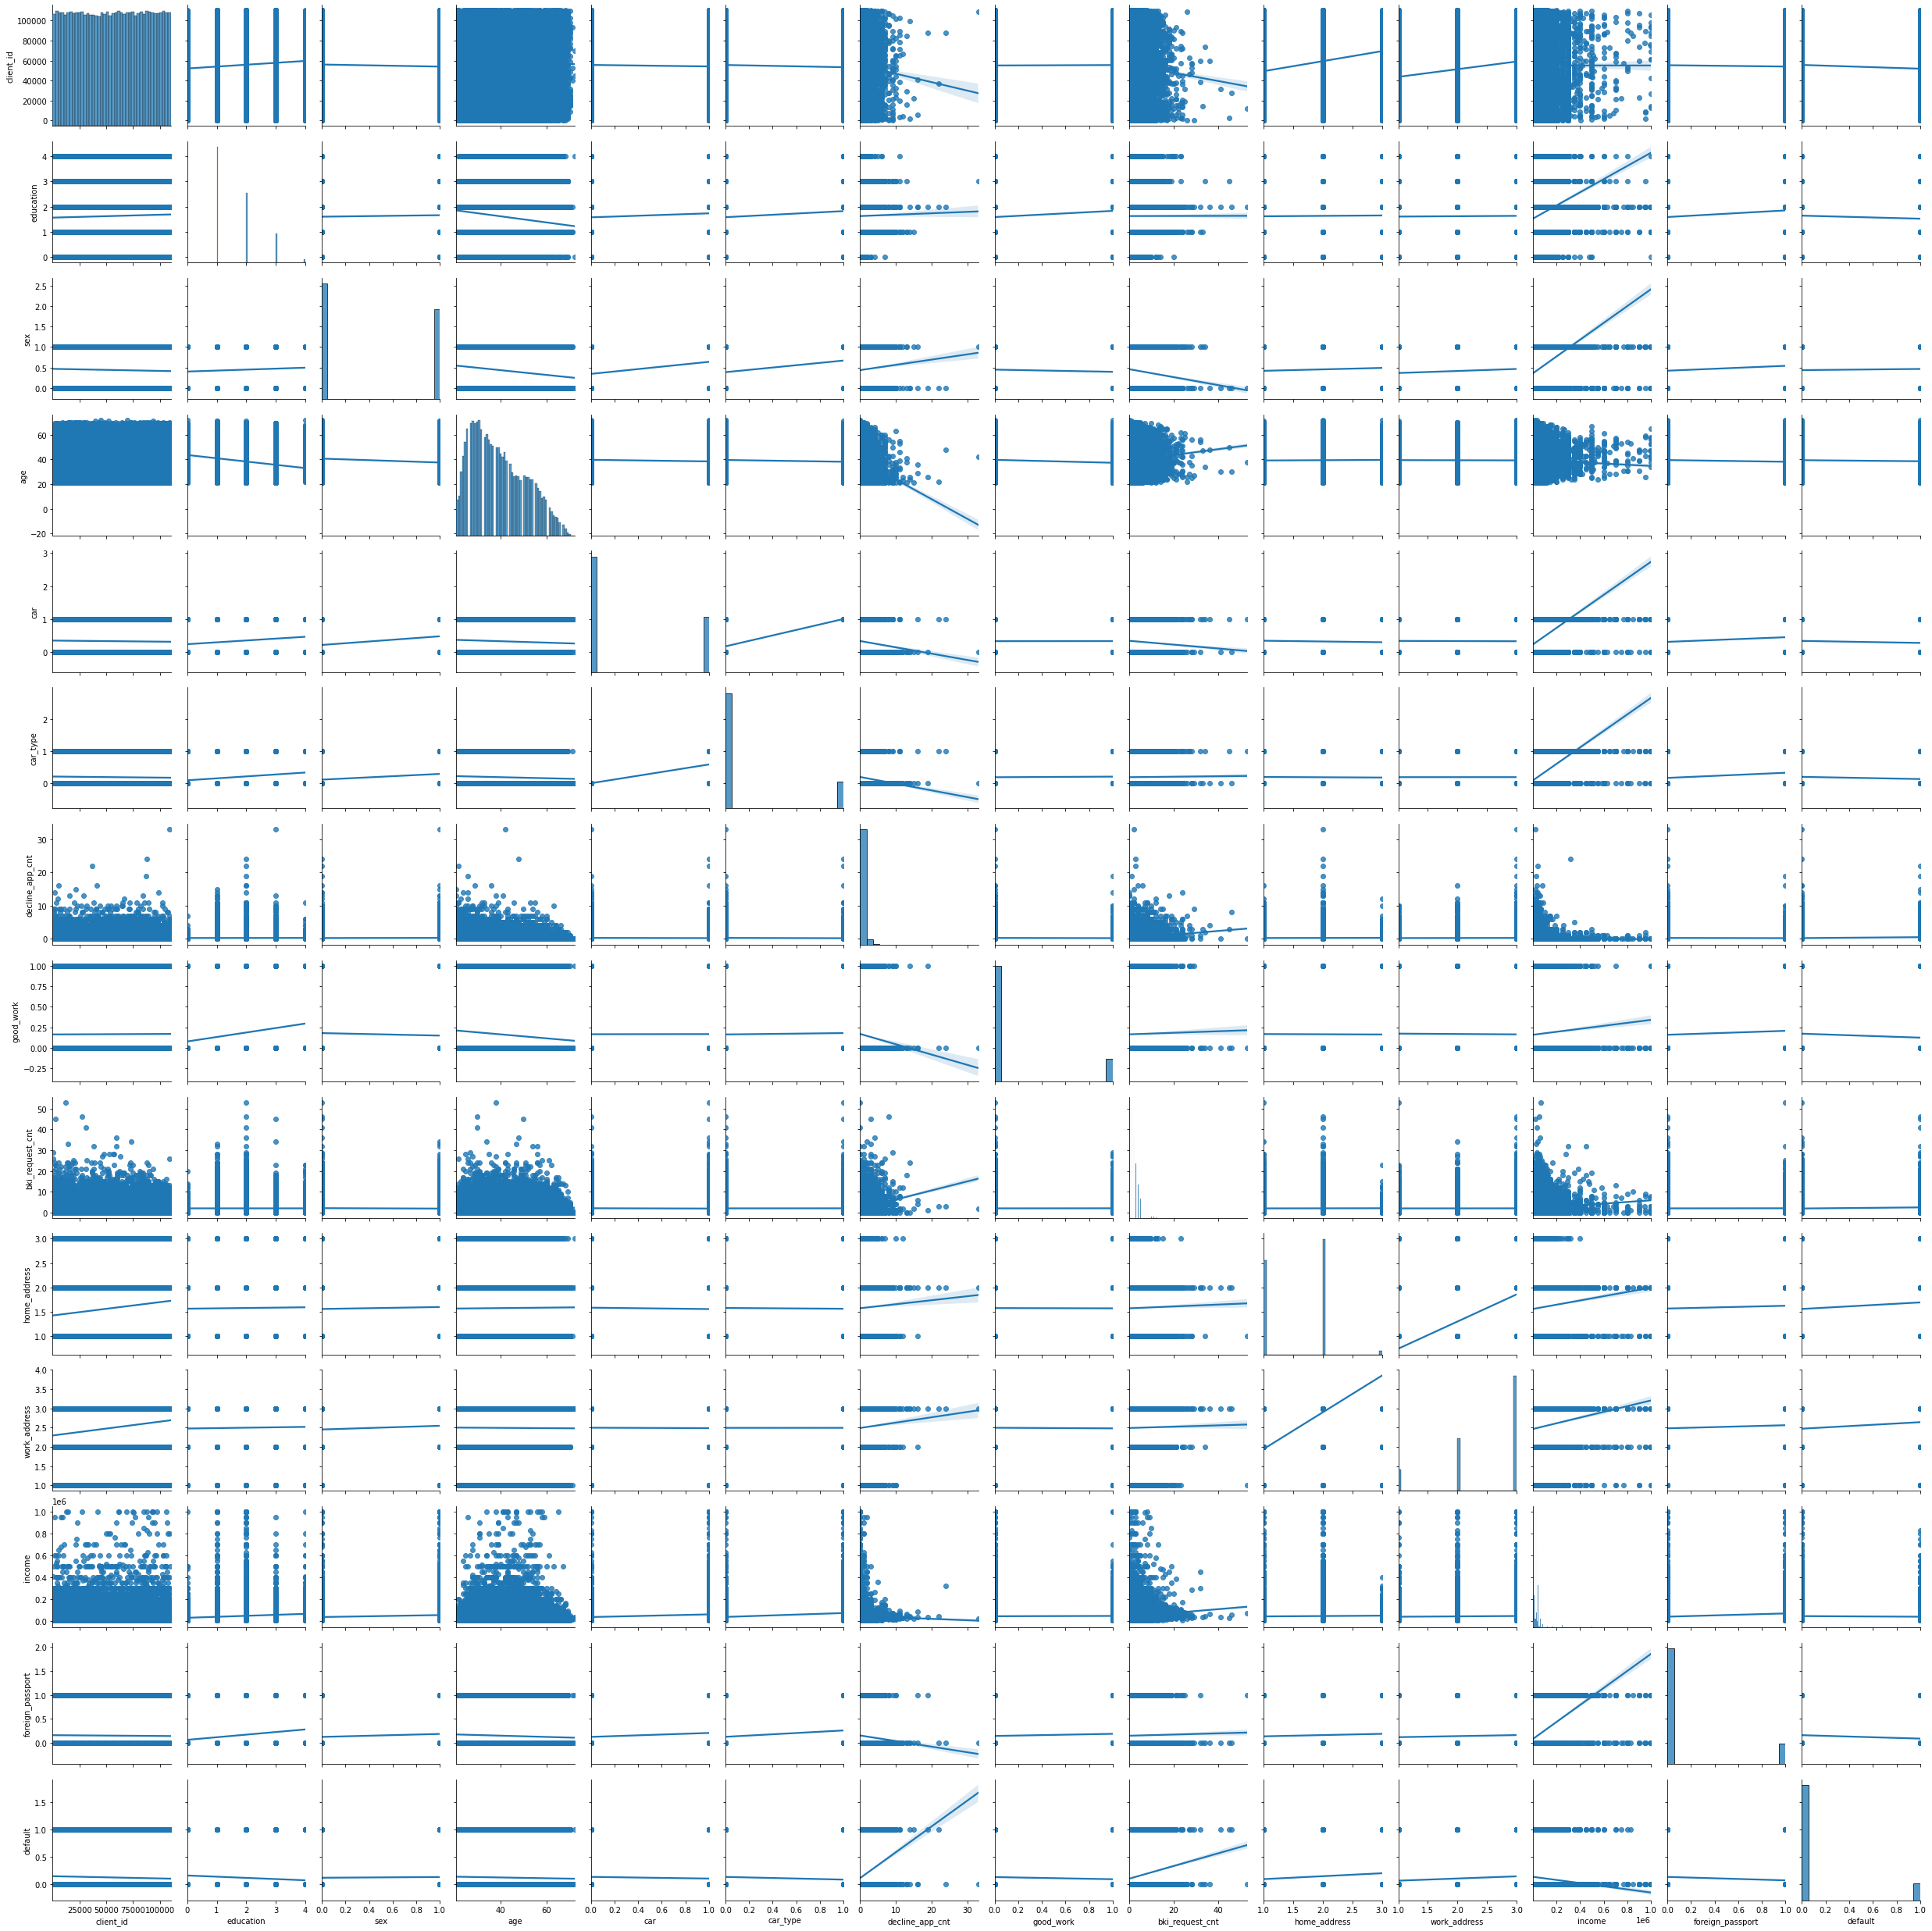

In [41]:
sns.pairplot(bank, kind = 'reg')

<AxesSubplot:>

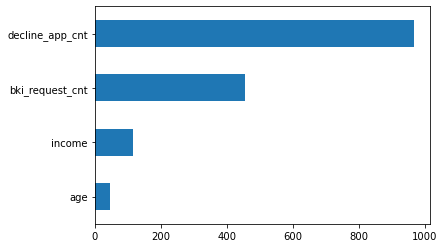

In [26]:
imp_num = Series(f_classif(bank[num_cols], bank['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [27]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(bank['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [28]:
# для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    bank[column] = label_encoder.fit_transform(bank[column])
    
# убедимся в преобразовании    
bank.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


In [30]:
bank['education'] = bank['education'].fillna(0)
bank['education'].value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
0        307
ACD      194
Name: education, dtype: int64

In [31]:
# присвоим значения каждому типу образования
education_dict = {'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':0, '0':0}

bank['education'] = bank['education'].replace(to_replace = education_dict)
bank['education'].value_counts()
bank.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,1,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,1,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,1,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,1,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,2,1,48,0,0,0,1,1,2,3,30000,1,0


In [32]:
bank['education'].value_counts()

1    38860
2    23365
3     9816
4     1257
0      501
Name: education, dtype: int64

<AxesSubplot:>

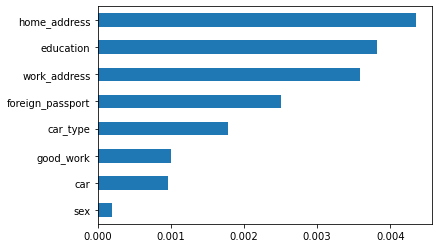

In [33]:
imp_cat = Series(mutual_info_classif(bank[bin_cols + cat_cols], bank['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [34]:
X_cat = OneHotEncoder(sparse = False).fit_transform(bank[cat_cols].values)
X_cat.shape

(73799, 11)

In [35]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   client_id         73799 non-null  int64
 1   education         73799 non-null  int64
 2   sex               73799 non-null  int64
 3   age               73799 non-null  int64
 4   car               73799 non-null  int64
 5   car_type          73799 non-null  int64
 6   decline_app_cnt   73799 non-null  int64
 7   good_work         73799 non-null  int64
 8   bki_request_cnt   73799 non-null  int64
 9   home_address      73799 non-null  int64
 10  work_address      73799 non-null  int64
 11  income            73799 non-null  int64
 12  foreign_passport  73799 non-null  int64
 13  default           73799 non-null  int64
dtypes: int64(14)
memory usage: 7.9 MB


In [36]:
# стандартизация числовых переменных
X_num = StandardScaler().fit_transform(bank[num_cols].values)

In [37]:
# объединяем
X = np.hstack([X_num, bank[bin_cols].values, X_cat])
Y = bank['default'].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

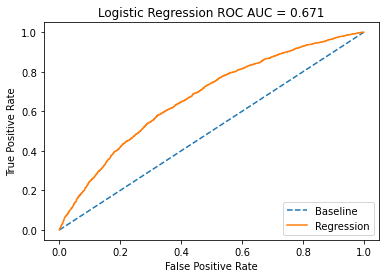

In [39]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [40]:
from sklearn.model_selection import GridSearchCV

# добавим типы регуляризации
penalty = ['l1', 'l2']

# зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# посмотрим на лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/varvar

/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/varvara/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/varvar

Лучшее Penalty: l2
Лучшее C: 1.0
